In [2]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Load distil_bert


In [3]:
# Load the model from the checkpoint
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Path to the saved checkpoint
checkpoint_path = "./results/bert/checkpoint-9900/"

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Load the model from the checkpoint directory
model = DistilBertForSequenceClassification.from_pretrained("./results/bert/checkpoint-9900")


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
test= pd.read_csv(Path(data_path,'test_data_only_text_and_labels.csv'))
test.head()

NameError: name 'data_path' is not defined

### Load Albert

In [2]:
# Load the model from the checkpoint
from transformers import AlbertForSequenceClassification, AlbertTokenizer

# Path to the saved checkpoint
checkpoint_path = "./results/albert/checkpoint-9900/"

# Load the tokenizer
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

# Load the model from the checkpoint directory
model = AlbertForSequenceClassification.from_pretrained(checkpoint_path)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
export_dir = Path(os.getcwd())
data_path = Path(export_dir, "data")

In [4]:
test= pd.read_csv(Path(data_path,'test_data_only_text_and_labels.csv'))
test.head()

,text_combined,label
0,press release dimitri paris 10 th december new...,1
1,ronan waide waiderwaiderie july 19 kevindated1...,0
2,adminviagracom unable see images email please ...,1
3,tyree puckett rollandduluthmcmahontypepadcom r...,1
4,location reminder wholesale retail power syste...,0


In [5]:
X_test = test["text_combined"].tolist()
y_test = test["label"]


Confusion Matrix:
[[7859   60]
 [  67 8512]]
Accuracy: 0.9923020972239059
Precision: 0.9930004666355576
Recall: 0.9921902319617671
F1-Score: 0.9925951839542884
AUC: 0.9996391809535706


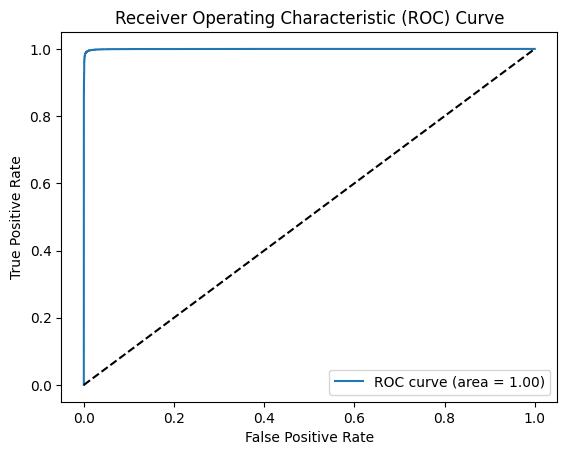

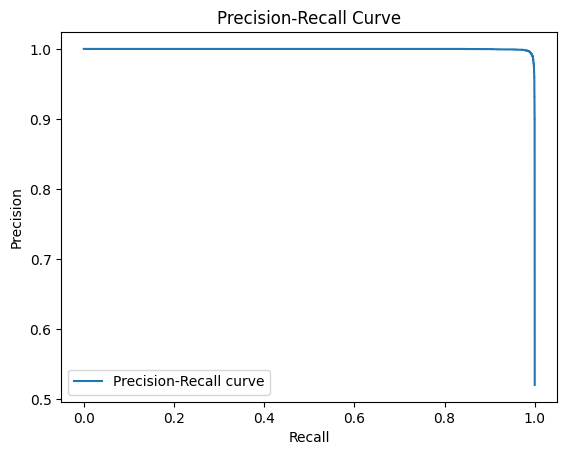

In [6]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import time
# Define device
device = torch.device("cpu")  # Change to "cuda" if GPU is available and required

# Move model to device
model.to(device)

# Convert DataFrame column to list of strings
texts = X_test

# Tokenize the texts
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
inputs = {key: value.to(device) for key, value in inputs.items()}

# Put model in evaluation mode
model.eval()
time_start = time.time()
# Get logits from the model
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    logits = logits.cpu()  # Ensure logits are on CPU
    probs = torch.nn.functional.softmax(logits, dim=-1).cpu()  # Ensure probs are on CPU
end_time = time.time()
running_time = end_time-start_time
# Get the predicted labels
predictions = torch.argmax(probs, dim=1).cpu()  # Ensure predictions are on CPU

# Assuming y_true and y_pred are the true and predicted labels respectively
y_true = y_test.values  # True labels (convert to numpy array)
y_pred = predictions.numpy()  # Predicted labels (convert to numpy array)
y_scores = probs[:, 1].numpy()  # Probabilities for the positive class (convert to numpy array)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("running_time:", running_time)
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)
print("AUC:", auc)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_scores)
plt.figure()
plt.plot(recall_vals, precision_vals, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


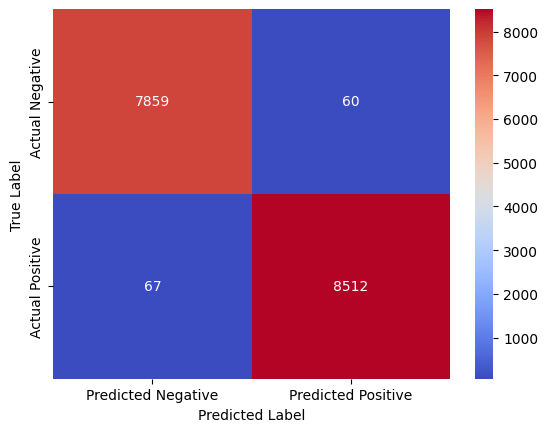

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Define the data matrix
data = cm

# Define axis labels
x_labels = ['Predicted Negative', 'Predicted Positive']
y_labels = ['Actual Negative', 'Actual Positive']

# Create the heatmap with values inside cells
ax = sns.heatmap(data, annot=True, fmt='d', cmap='coolwarm', cbar=True, 
                 xticklabels=x_labels, yticklabels=y_labels)

# Set axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()


### Load Roberta

In [11]:
# Load the model from the checkpoint
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Path to the saved checkpoint
checkpoint_path = "./results/roberta/checkpoint-9900/"

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

# Load the model from the checkpoint directory
model = RobertaForSequenceClassification.from_pretrained(checkpoint_path)


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
export_dir = Path(os.getcwd())
data_path = Path(export_dir, "data")

In [20]:
Path(data_path,'test_data_only_text_and_labels.csv')

PosixPath('/storage/ronelias/advanced_topics_dl/data/test_data_only_text_and_labels.csv')

In [13]:
test= pd.read_csv(Path(data_path,'test_data_only_text_and_labels.csv'))
test.head()

,text_combined,label
0,press release dimitri paris 10 th december new...,1
1,ronan waide waiderwaiderie july 19 kevindated1...,0
2,adminviagracom unable see images email please ...,1
3,tyree puckett rollandduluthmcmahontypepadcom r...,1
4,location reminder wholesale retail power syste...,0


In [14]:
X_test = test["text_combined"].tolist()
y_test = test["label"]


Confusion Matrix:
[[7842   77]
 [  62 8517]]
Accuracy: 0.9915747363316766
Precision: 0.991040260646963
Recall: 0.992773050472083
F1-Score: 0.9919058987946194
AUC: 0.9993062406357316


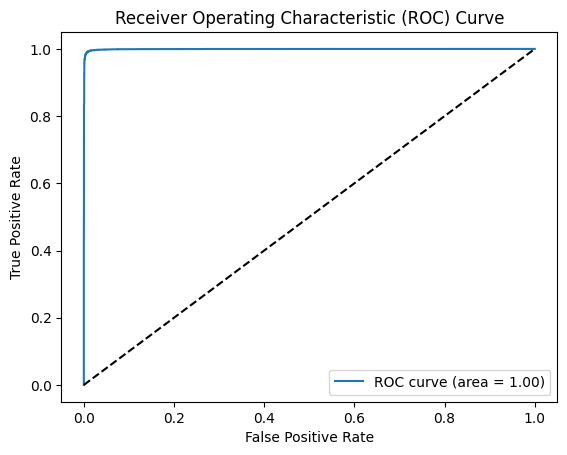

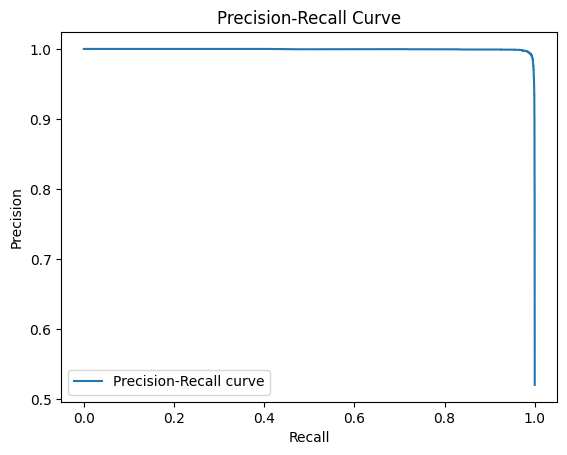

In [15]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Define device
device = torch.device("cpu")  # Change to "cuda" if GPU is available and required

# Move model to device
model.to(device)

# Convert DataFrame column to list of strings
texts = X_test

# Tokenize the texts
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
inputs = {key: value.to(device) for key, value in inputs.items()}

# Put model in evaluation mode
model.eval()

# Get logits from the model
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    logits = logits.cpu()  # Ensure logits are on CPU
    probs = torch.nn.functional.softmax(logits, dim=-1).cpu()  # Ensure probs are on CPU

# Get the predicted labels
predictions = torch.argmax(probs, dim=1).cpu()  # Ensure predictions are on CPU

# Assuming y_true and y_pred are the true and predicted labels respectively
y_true = y_test.values  # True labels (convert to numpy array)
y_pred = predictions.numpy()  # Predicted labels (convert to numpy array)
y_scores = probs[:, 1].numpy()  # Probabilities for the positive class (convert to numpy array)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)
print("AUC:", auc)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_scores)
plt.figure()
plt.plot(recall_vals, precision_vals, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


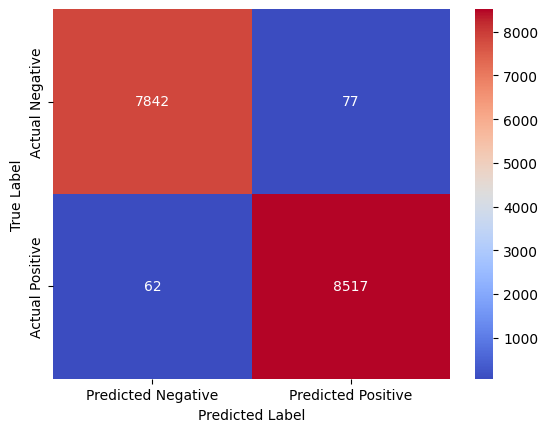

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Define the data matrix
data = cm

# Define axis labels
x_labels = ['Predicted Negative', 'Predicted Positive']
y_labels = ['Actual Negative', 'Actual Positive']

# Create the heatmap with values inside cells
ax = sns.heatmap(data, annot=True, fmt='d', cmap='coolwarm', cbar=True, 
                 xticklabels=x_labels, yticklabels=y_labels)

# Set axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()


In [18]:
def get_model_size(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / (1024 ** 2)  # Size in MB
get_model_size(model)

1355.5976638793945

In [19]:
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters: {total_params}")

Total number of parameters: 355361794


### Load Roberta - distilled

In [28]:
# Load the model from the checkpoint
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Path to the saved checkpoint
checkpoint_path = "./results/roberta/fine_tune/distilled_model/checkpoint-3300/"

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

# Load the model from the checkpoint directory
model = RobertaForSequenceClassification.from_pretrained(checkpoint_path)


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
export_dir = Path(os.getcwd())
data_path = Path(export_dir, "data")

In [30]:
Path(data_path,'test_data_only_text_and_labels.csv')

PosixPath('/storage/ronelias/advanced_topics_dl/data/test_data_only_text_and_labels.csv')

In [31]:
test= pd.read_csv(Path(data_path,'test_data_only_text_and_labels.csv'))
test.head()

,text_combined,label
0,press release dimitri paris 10 th december new...,1
1,ronan waide waiderwaiderie july 19 kevindated1...,0
2,adminviagracom unable see images email please ...,1
3,tyree puckett rollandduluthmcmahontypepadcom r...,1
4,location reminder wholesale retail power syste...,0


In [32]:
X_test = test["text_combined"].tolist()
y_test = test["label"]


Confusion Matrix:
[[7750  169]
 [  81 8498]]
Accuracy: 0.9848466480785549
Precision: 0.980500749971155
Recall: 0.9905583401328826
F1-Score: 0.985503884958831
AUC: 0.9987151203287288


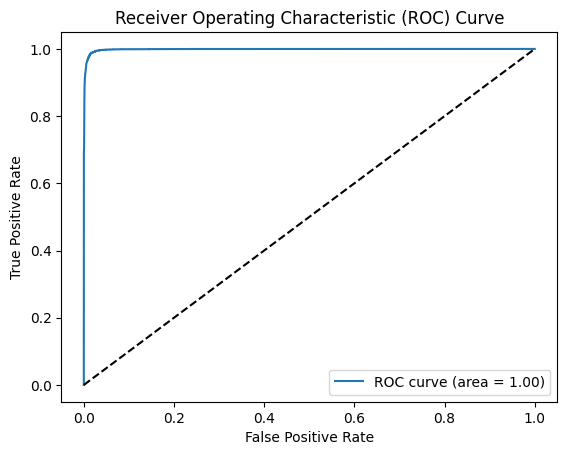

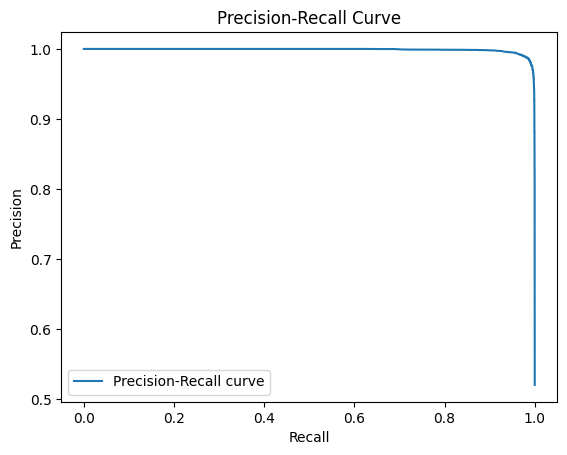

In [33]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Define device
device = torch.device("cpu")  # Change to "cuda" if GPU is available and required

# Move model to device
model.to(device)

# Convert DataFrame column to list of strings
texts = X_test

# Tokenize the texts
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
inputs = {key: value.to(device) for key, value in inputs.items()}

# Put model in evaluation mode
model.eval()

# Get logits from the model
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    logits = logits.cpu()  # Ensure logits are on CPU
    probs = torch.nn.functional.softmax(logits, dim=-1).cpu()  # Ensure probs are on CPU

# Get the predicted labels
predictions = torch.argmax(probs, dim=1).cpu()  # Ensure predictions are on CPU

# Assuming y_true and y_pred are the true and predicted labels respectively
y_true = y_test.values  # True labels (convert to numpy array)
y_pred = predictions.numpy()  # Predicted labels (convert to numpy array)
y_scores = probs[:, 1].numpy()  # Probabilities for the positive class (convert to numpy array)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)
print("AUC:", auc)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_scores)
plt.figure()
plt.plot(recall_vals, precision_vals, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


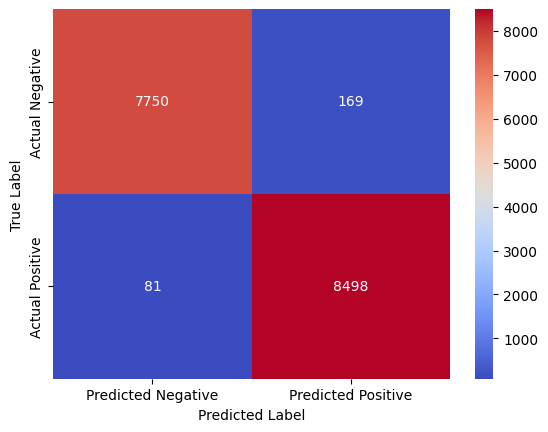

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Define the data matrix
data = cm

# Define axis labels
x_labels = ['Predicted Negative', 'Predicted Positive']
y_labels = ['Actual Negative', 'Actual Positive']

# Create the heatmap with values inside cells
ax = sns.heatmap(data, annot=True, fmt='d', cmap='coolwarm', cbar=True, 
                 xticklabels=x_labels, yticklabels=y_labels)

# Set axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()


In [26]:
def get_model_size(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / (1024 ** 2)  # Size in MB
get_model_size(model)

475.49121856689453

In [27]:
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters: {total_params}")

Total number of parameters: 124647170


### Load Roberta-base model without distilation


In [43]:
# Load the model from the checkpoint
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Path to the saved checkpoint
checkpoint_path = "./results/roberta-base_20_epochs/checkpoint-6600/"

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Load the model from the checkpoint directory
model = RobertaForSequenceClassification.from_pretrained(checkpoint_path)


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [36]:
export_dir = Path(os.getcwd())
data_path = Path(export_dir, "data")

In [37]:
Path(data_path,'test_data_only_text_and_labels.csv')

PosixPath('/storage/ronelias/advanced_topics_dl/data/test_data_only_text_and_labels.csv')

In [38]:
test= pd.read_csv(Path(data_path,'test_data_only_text_and_labels.csv'))
test.head()

,text_combined,label
0,press release dimitri paris 10 th december new...,1
1,ronan waide waiderwaiderie july 19 kevindated1...,0
2,adminviagracom unable see images email please ...,1
3,tyree puckett rollandduluthmcmahontypepadcom r...,1
4,location reminder wholesale retail power syste...,0


In [39]:
X_test = test["text_combined"].tolist()
y_test = test["label"]


Confusion Matrix:
[[7866   53]
 [  73 8506]]
Accuracy: 0.9923627106315918
Precision: 0.993807687813997
Recall: 0.9914908497493881
F1-Score: 0.9926479169097912
AUC: 0.9996775326047544


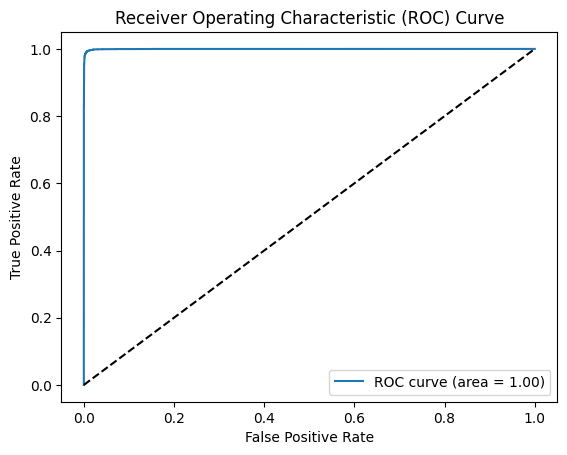

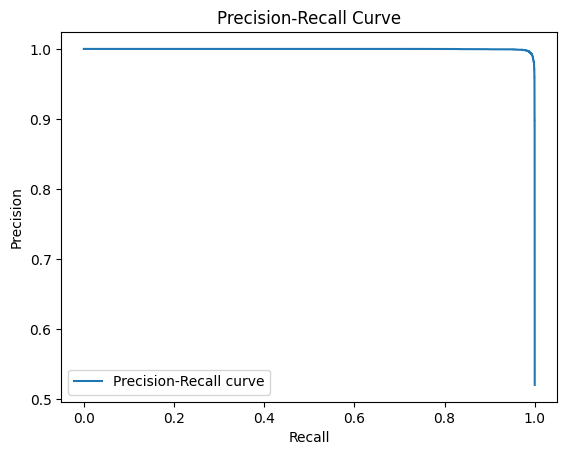

In [46]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import time
# Define device
device = torch.device("cpu")  # Change to "cuda" if GPU is available and required

# Move model to device
model.to(device)

# Convert DataFrame column to list of strings
texts = X_test

# Tokenize the texts
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
inputs = {key: value.to(device) for key, value in inputs.items()}

# Put model in evaluation mode
model.eval()
time_start = time.time()
# Get logits from the model
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    logits = logits.cpu()  # Ensure logits are on CPU
    probs = torch.nn.functional.softmax(logits, dim=-1).cpu()  # Ensure probs are on CPU
end_time = time.time()
running_time = end_time-start_time
# Get the predicted labels
predictions = torch.argmax(probs, dim=1).cpu()  # Ensure predictions are on CPU

# Assuming y_true and y_pred are the true and predicted labels respectively
y_true = y_test.values  # True labels (convert to numpy array)
y_pred = predictions.numpy()  # Predicted labels (convert to numpy array)
y_scores = probs[:, 1].numpy()  # Probabilities for the positive class (convert to numpy array)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)
print("AUC:", auc)
print("running_time:", running_time)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_scores)
plt.figure()
plt.plot(recall_vals, precision_vals, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


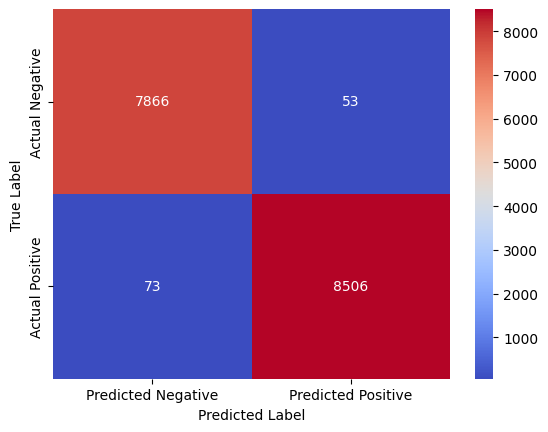

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Define the data matrix
data = cm

# Define axis labels
x_labels = ['Predicted Negative', 'Predicted Positive']
y_labels = ['Actual Negative', 'Actual Positive']

# Create the heatmap with values inside cells
ax = sns.heatmap(data, annot=True, fmt='d', cmap='coolwarm', cbar=True, 
                 xticklabels=x_labels, yticklabels=y_labels)

# Set axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()


In [45]:
def get_model_size(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / (1024 ** 2)  # Size in MB
get_model_size(model)

475.49121856689453

In [44]:
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters: {total_params}")

Total number of parameters: 124647170


In [48]:
print(f"Total number of parameters: {total_params}")

Total number of parameters: 124647170


### Load quantized roberta model

In [3]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 1. Recreate the model architecture
from transformers import RobertaConfig, RobertaForSequenceClassification

# # 1. Load the configuration from the pretrained model
# config = RobertaConfig.from_pretrained("roberta-large")

# # 2. Initialize the model with the configuration
# model = RobertaForSequenceClassification(config)


# # 2. Load the saved quantized state dictionary
# quantized_model_save_path = "./results/roberta/fine_tune/quant/quantized_model.pth"
# model.load_state_dict(torch.load(quantized_model_save_path))

# Load the entire model
model = torch.load("./results/roberta/fine_tune/quant/quantized_model.pth")


/opt/conda/lib/python3.10/site-packages/torch/_utils.py:382: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [5]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
export_dir = Path(os.getcwd())
data_path = Path(export_dir, "data")

In [7]:
Path(data_path,'test_data_only_text_and_labels.csv')

PosixPath('/storage/ronelias/advanced_topics_dl/data/test_data_only_text_and_labels.csv')

In [8]:
test= pd.read_csv(Path(data_path,'test_data_only_text_and_labels.csv'))
test.head()
X_test = test["text_combined"].tolist()
y_test = test["label"]


In [1]:
16498/4



4124.5

Confusion Matrix:
[[7849   70]
 [  63 8516]]
Accuracy: 0.9919384167777913
Precision: 0.9918471931050548
Recall: 0.9926564867700198
F1-Score: 0.9922516749198952
AUC: 0.9975133984595544
eval_time: 8673.028543233871


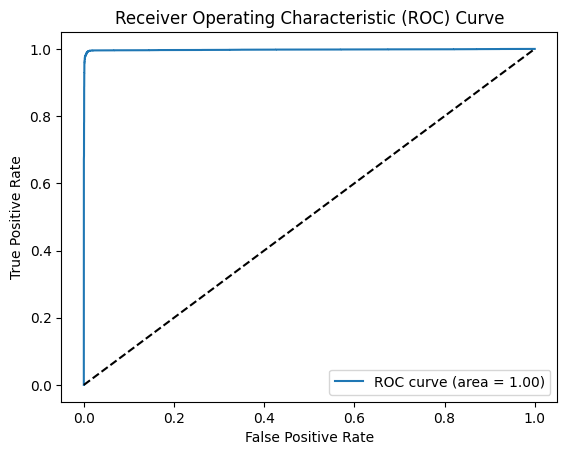

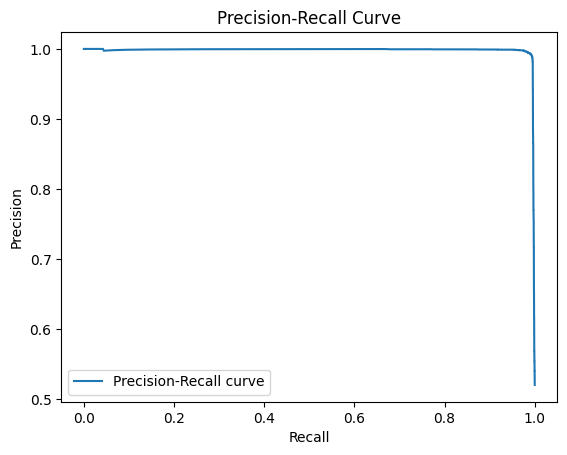

In [11]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import time
# Function to evaluate the model on the test set in batches
def evaluate_in_batches(model, tokenizer, X_test, y_test, batch_size):
    device = torch.device("cpu")  # Change to "cuda" if GPU is available and required
    model.to(device)
    model.eval()

    # Split the test set into batches
    num_batches = len(X_test) // batch_size + (1 if len(X_test) % batch_size != 0 else 0)

    all_predictions = []
    all_probs = []
    all_true_labels = []
    start_time = time.time()
    with torch.no_grad():
        for i in range(num_batches):
            # Get the batch data
            batch_texts = X_test[i * batch_size: (i + 1) * batch_size]
            batch_labels = y_test[i * batch_size: (i + 1) * batch_size]

            # Tokenize the batch
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
            inputs = {key: value.to(device) for key, value in inputs.items()}

            # Get logits from the model
            outputs = model(**inputs)
            logits = outputs.logits.cpu()
            probs = torch.nn.functional.softmax(logits, dim=-1).cpu()

            # Get the predicted labels
            predictions = torch.argmax(probs, dim=1).cpu()

            # Store the results
            all_predictions.append(predictions.numpy())
            all_probs.append(probs[:, 1].numpy())
            all_true_labels.append(batch_labels.to_numpy())

    # Concatenate all batch results
    y_pred = np.concatenate(all_predictions)
    y_scores = np.concatenate(all_probs)
    y_true = np.concatenate(all_true_labels)
    total_time = time.time() - start_time
    # Calculate evaluation metrics
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)
    evaluation_results = {
        "Confusion_Matrix": cm,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "Evaluation_Time": total_time
    }
    # Print results
    print("Confusion Matrix:")
    print(cm)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("AUC:", auc)
    print("eval_time:", total_time)
    # ROC Curve
    with open(f'./results/roberta/fine_tune/quant/quantized_model_eval_results.txt', 'w') as f:
        f.write(f"{evaluation_results}\n\n")
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_scores)
    plt.figure()
    plt.plot(recall_vals, precision_vals, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    return cm
# Example usage
batch_size = 500  # Set the desired batch size
cm = evaluate_in_batches(model, tokenizer, X_test, y_test, batch_size)

 

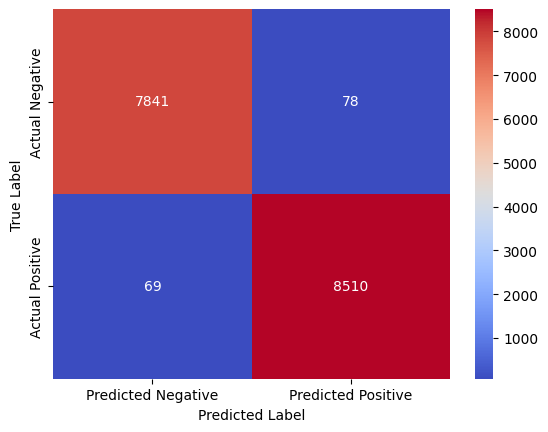

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Define the data matrix
data = cm

# Define axis labels
x_labels = ['Predicted Negative', 'Predicted Positive']
y_labels = ['Actual Negative', 'Actual Positive']

# Create the heatmap with values inside cells
ax = sns.heatmap(data, annot=True, fmt='d', cmap='coolwarm', cbar=True, 
                 xticklabels=x_labels, yticklabels=y_labels)

# Set axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()


In [23]:
def get_model_size(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / (1024 ** 2)  # Size in MB
get_model_size(model)

198.7421875

In [24]:
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters: {total_params}")

Total number of parameters: 52099072
